Dataset name: Stanford Sentiment Treebank (SST-2)
Dataset link:https://huggingface.co/datasets/stanfordnlp/sst2/tree/main/data
Different from what I expected in my proposal, the SST-2 dataset used here is a simplified version with 3 emotion classes (negative -1, neutral 0, positive 1) instead of 5 to accelerate training.

I will use the optimal model trained to compare the accuracies and running time with those of a complex Distil-Bert Model.

In [ ]:
import pandas as pd
from pandas import read_parquet
import numpy as np



In [ ]:
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
import time

In [ ]:
# RE Library for Regular Expression
import re

# NLTK Library for Natural Language Processing
import nltk
nltk.download('stopwords') # Downloading the Stopwords

# Stopwords for removing stopwords in the Text
from nltk.corpus import stopwords

# PorterStemmer for Stemming the Words
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yihangyang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold

In [ ]:
test_data = read_parquet("test.parquet")
print(test_data.count())
test_data.head()

idx         1821
sentence    1821
label       1821
dtype: int64


,idx,sentence,label
0,0,uneasy mishmash of styles and genres .,-1
1,1,this film 's relationship to actual tension is...,-1
2,2,"by the end of no such thing the audience , lik...",-1
3,3,director rob marshall went out gunning to make...,-1
4,4,lathan and diggs have considerable personal ch...,-1


In [ ]:
train_data = read_parquet("train.parquet")
print(train_data.count())
train_data.head()

idx         67349
sentence    67349
label       67349
dtype: int64


,idx,sentence,label
0,0,hide new secretions from the parental units,0
1,1,"contains no wit , only labored gags",0
2,2,that loves its characters and communicates som...,1
3,3,remains utterly satisfied to remain the same t...,0
4,4,on the worst revenge-of-the-nerds clichés the ...,0


In [ ]:
val_data = read_parquet("validation.parquet")
print(val_data.count())
val_data.head()

idx         872
sentence    872
label       872
dtype: int64


,idx,sentence,label
0,0,it 's a charming and often affecting journey .,1
1,1,unflinchingly bleak and desperate,0
2,2,allows us to hope that nolan is poised to emba...,1
3,3,"the acting , costumes , music , cinematography...",1
4,4,"it 's slow -- very , very slow .",0


In [ ]:
data_list = [train_data, test_data, val_data]
data = pd.concat(data_list, ignore_index=True)


<Axes: xlabel='label'>

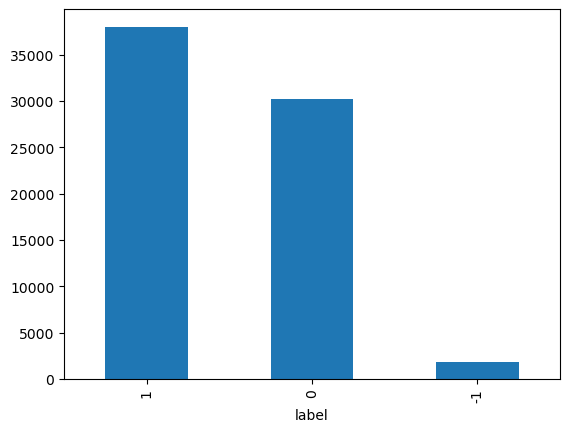

In [ ]:
data['label'].value_counts().plot(kind='bar')

In [ ]:
shuffled_df = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
train_data = shuffled_df[0:67349]
val_data = shuffled_df[67349:67349+872]
test_data = shuffled_df[-1821:]
#keep original length after shuffled

In [ ]:
data_list = [train_data, test_data, val_data]

In [ ]:
Y_train = train_data['label']
Y_train = np.array(Y_train)
print(Y_train.shape)# Shuffle the rows randomly



(67349,)


In [ ]:
Y_val = np.array(val_data['label'])

NLP techniques I apply include textcleaning, tokenization (splitting words), stopword removal and stemming.

In [ ]:
important_words = {'no','not','only','few','most','more','nor','just',"don't"}

In [ ]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
stopwords.words('english')[144:]

['aren',
 "aren't",
 'couldn',
 "couldn't",
 'didn',
 "didn't",
 'doesn',
 "doesn't",
 'hadn',
 "hadn't",
 'hasn',
 "hasn't",
 'haven',
 "haven't",
 'isn',
 "isn't",
 'ma',
 'mightn',
 "mightn't",
 'mustn',
 "mustn't",
 'needn',
 "needn't",
 'shan',
 "shan't",
 'shouldn',
 "shouldn't",
 'wasn',
 "wasn't",
 'weren',
 "weren't",
 'won',
 "won't",
 'wouldn',
 "wouldn't"]

In [ ]:
mod_stopwords = set(stopwords.words('english')[:144])
mod_stopwords = (mod_stopwords - important_words) | {'would','could','us','one'}

In [ ]:
ps = PorterStemmer()
corpus = [None,None,None]
for i in range(len(data_list)):
    #print(data_list[i])
    data_item = data_list[i]
    #print(data_item)
    corpus_item = []
    for j in range(0, len(data_item)):
        review = re.sub('[^a-zA-Z]', ' ', data_item.iloc[j]['sentence']) #textcleaning
        review = review.split() #tokenization
        review = [ps.stem(word) for word in review if not word in mod_stopwords]
        review = ' '.join(review)
        corpus_item.append(review)
    corpus[i] = corpus_item

# Printing the first 5 values in the corpus list
corpus[0][1:6]

['subzero version',
 'sheer beauti imag',
 'f rom perform cinematographi outstand soundtrack unconvent narr film blazingli aliv admir mani level',
 'monotoni',
 'intox show']

To extract features, I plan to combine Word2Vec and N-Gram to generate feature maps that will serve as input to multiple classifiers.

In [ ]:

#Use gridsearch to find best vectorsize for n-grams (1000)

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2))),
    ('classifier', MultinomialNB())
])

# Define the hyperparameter grid
param_grid = {
    'vectorizer__max_features': [200,500, 800, 1000]
}

# Perform grid search with cross-validation
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid.fit(corpus[0], Y_train)

# Print best parameter and corresponding accuracy
print("Best max_features:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

# Evaluate on the test set
best_model = grid.best_estimator_  # Extract the best model from GridSearchCV
Y_val_pred = best_model.predict(corpus[2])  # Make predictions on the val set
test_accuracy = accuracy_score(Y_val, Y_val_pred)

print(f"Accuracy on validation set: {test_accuracy:.4f}")

Best max_features: {'vectorizer__max_features': 1000}
Best cross-validation accuracy: 0.7449998459439128
Accuracy on validation set: 0.7534


In [ ]:
#N-gram vectorizer: indicate frequencies of the vocabulary

vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=1000)
X_ngram = vectorizer.fit_transform(corpus[0]).toarray()
X_val_ngram = vectorizer.fit_transform(corpus[2]).toarray()




In [ ]:
from gensim.models import Word2Vec

In [ ]:
#Word2Vec is a 2-layer neural network model to extract features
tokenized_corpus = [sentence.split() for sentence in corpus[0]]

w2v_model = Word2Vec(sentences=tokenized_corpus, vector_size=500, min_count=1, workers=4)

In [ ]:

# Average Word2Vec embeddings for each sentence
def sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size) #vector_size=500

X_word2vec = np.array([sentence_vector(sentence, w2v_model) for sentence in tokenized_corpus])

# Print Word2Vec features for the first sentence
print("Word2Vec Embedding for First Sentence:\n", X_word2vec[0])

Word2Vec Embedding for First Sentence:
 [ 0.04084814  0.10459438  0.15509938  0.14370911 -0.09598421 -0.17787018
 -0.02711659  0.2830354   0.06176409 -0.04201972 -0.07946269  0.11865851
 -0.05707281  0.01412908  0.07245509 -0.20779525 -0.17897494 -0.09192131
  0.01683621 -0.00578837  0.0170438  -0.04536177  0.16699032 -0.07312913
  0.07576555  0.04559565  0.0299239   0.02471589 -0.28388292 -0.07039511
  0.08653116  0.01580531 -0.0248969  -0.09796158  0.07739273  0.01388026
 -0.04393767 -0.13001896 -0.04284158 -0.22743167 -0.03392762  0.0205349
 -0.22444452  0.09065197 -0.10749879 -0.11479199 -0.09984898  0.08908024
 -0.01940112  0.00652712 -0.01369413  0.0084204  -0.04654437 -0.15231065
  0.04139282 -0.05530087  0.13659054 -0.03381889 -0.01118298  0.04812726
  0.09639563  0.06736723 -0.0334727  -0.06425188 -0.05030757  0.13762385
 -0.0771271   0.084408    0.10299701  0.01034339 -0.12293702  0.07937682
  0.06839343 -0.06552234  0.17721987  0.1712493  -0.03080879  0.04971343
  0.10322207

In [ ]:
tokenized_corpus_val = [sentence.split() for sentence in corpus[2]]
X_val_word2vec = np.array([sentence_vector(sentence, w2v_model) for sentence in tokenized_corpus_val])

In [ ]:
print(len(X_word2vec[0]))
# Standardize the feature map for GaussianNB
scaler = StandardScaler()
X_word2vec_scaled = scaler.fit_transform(X_word2vec)


500


In [ ]:
print(np.sum(X_word2vec_scaled[:,0]),np.sum(X_word2vec_scaled[:,1])) #close to 0
#print(X_word2vec[0])


-1.0381029369455064e-11 2.1280754936015e-12


In [ ]:
X_val_word2vec_scaled = scaler.fit_transform(X_val_word2vec)

In [ ]:
# Initialize and fit the GaussianNB model; use only scaled word2vec
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_word2vec_scaled, Y_train)

# Predict on the test set
Y_pred = gnb_classifier.predict(X_val_word2vec_scaled)

# Evaluate accuracy
accuracy = accuracy_score(Y_val, Y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.33


Since the result of GuassianNB has low accuracy and another bayes classifier MultinormialNB has been applied, I give up this model.

In [ ]:
# Combine CountVectorizer and Word2Vec features

# Apply PCA to reduce the dimensions of n-grams map
pca = PCA(n_components=500)  # Reduce to 1000 dimensions
X_ng_reduced = pca.fit_transform(X_ngram)
Xval_ngreduced = pca.fit_transform(X_val_ngram)
print("Reduced feature size:", X_ng_reduced.shape)

Reduced feature size: (67349, 500)


In [ ]:
#Continue combining
X_combined = np.hstack((X_ng_reduced, X_word2vec_scaled))
Xval_combined = np.hstack((Xval_ngreduced, X_val_word2vec_scaled))
# Print combined feature shape
print("Shape of Combined Features:", X_combined.shape)


Shape of Combined Features: (67349, 1000)


In [ ]:
X_combined = scaler.fit_transform(X_combined)
#do one more scaling to improve learning efficiency

In [ ]:
Xval_combined = scaler.fit_transform(Xval_combined)

In [ ]:
# Initialize the Random Forest Classifier
rf = RandomForestClassifier(max_depth=14)

# Define the parameter grid for 'n_estimators'
param_rf = {'max_depth': list(range(12, 15)), 'max_features': list(range(10,15))} #20 models


# Set up GridSearchCV
grid = GridSearchCV(estimator=rf, param_grid=param_rf, scoring='accuracy', n_jobs=-1)

# Perform grid search
grid.fit(X_combined, Y_train)

In [ ]:
# Print the best parameter and corresponding score
print("Best parameters", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

# Evaluate on the test set using the best model
best_rf = grid.best_estimator_
Y_pred = best_rf.predict(Xval_combined)
test_accuracy = accuracy_score(Y_val, Y_pred)
print(f"Test accuracy with best n_estimators (grid.best_params_): {test_accuracy:.4f}")

Best n_estimators: {'max_depth': 14, 'max_features': 11}
Best cross-validation accuracy: 0.8362261241312849
Test accuracy with best n_estimators (grid.best_params_): 0.6606


In [ ]:

#Random Forest based on X_combined

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(max_depth=14,max_features=11)

# Train the model on the training data
rf_classifier.fit(X_combined, Y_train)

# Predict on the test data
Y_pred = rf_classifier.predict(Xval_combined)

# Evaluate the model's performance
accuracy = accuracy_score(Y_val, Y_pred)

print(f"Random Forest Classifier Accuracy: {accuracy:.2f}")


Random Forest Classifier Accuracy: 0.68


In [ ]:
svm = SVC(max_iter=1200)
svm_para = [{'kernel': ['linear']},
             {'kernel': ['poly'], 'degree': [2, 3]},
             {'kernel': ['rbf']}]
grid_svc = GridSearchCV(estimator= svm,param_grid=svm_para)
grid_svc.fit(X_combined, Y_train)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_i

GridSearchCV(estimator=SVC(max_iter=1200),
             param_grid=[{'kernel': ['linear']},
                         {'degree': [2, 3], 'kernel': ['poly']},
                         {'kernel': ['rbf']}])

In [ ]:
print(grid_svc.best_params_)
print("Best cross-validation accuracy:", grid_svc.best_score_)

# Evaluate on the test set using the best model
best_svc = grid_svc.best_estimator_
Y_pred = best_svc.predict(Xval_combined)
test_accuracy = accuracy_score(Y_val, Y_pred)
print(f"Test accuracy with best params (grid.best_params_): {test_accuracy:.4f}")

{'kernel': 'linear'}
Best cross-validation accuracy: 0.5632591411342817
Test accuracy with best n_estimators (grid.best_params_): 0.5241


In [ ]:
# Train the SVM model with a max_iter of 20000
start_time = time.time()
svm = SVC(kernel='linear', C=1, max_iter=20000)
svm.fit(X_combined, Y_train)
end_time = time.time()

print(f"Training time: {start_time - end_time:.4f} seconds")

Training time: -1296.8221 seconds


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [ ]:
Y_pred = svm.predict(Xval_combined)
test_accuracy = accuracy_score(Y_val, Y_pred)
print(test_accuracy)

0.6089449541284404


Due to the limitation of device, it is hard to run SVM until converge. Until tried 5000 max_iter to run about 8,9 minutes, the accuracy is still low. Therefore, SVM might be inappropriate for this task.

In [ ]:
#merge models and calculate speed
#!!!!!test time record
start_tt = time.time()
Y_test = np.array(test_data['label'])
X_test_ngram = vectorizer.fit_transform(corpus[1]).toarray()
Xtest_ngreduced = pca.fit_transform(X_test_ngram)

tokenized_corpus_test = [sentence.split() for sentence in corpus[1]]
X_test_word2vec = np.array([sentence_vector(sentence, w2v_model) for sentence in tokenized_corpus_test])
Xtest_w2vcscaled = scaler.fit_transform(X_test_word2vec)

Xtest_combined = np.hstack((Xtest_ngreduced, Xtest_w2vcscaled))
Xtest_combined = scaler.fit_transform(Xtest_combined)


Y_test_pred = best_model.predict(corpus[1])  # Make predictions on the val set
Bayes_test_accuracy = accuracy_score(Y_test, Y_test_pred)

Y_test_pred2 = rf_classifier.predict(Xtest_combined)
RF_test_accuracy = accuracy_score(Y_test, Y_test_pred2)



end_tt = time.time()
print(f"Multinormial Bayes Classifier has accuracy on test set: {Bayes_test_accuracy:.4f}")
print(f"Random Forest Classifier Accuracy: {RF_test_accuracy:.2f}")
print(f'Running time:{end_tt-start_tt:.2f} seconds')

Multinormial Bayes Classifier has accuracy on test set: 0.7408
Random Forest Classifier Accuracy: 0.71
Running time:1.07 seconds
